In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import math
import os
import cv2 as cv

from scipy import ndimage
from pymba import Vimba
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from PIL import Image
from beam_fit import *
from imaging import *


In [2]:
%load_ext autoreload
%autoreload 2

In [65]:
image = take_single_shot(300)
print(image.shape)
print(np.max(image))


(3036, 4024)
198


Max pixel count in cropped image 198


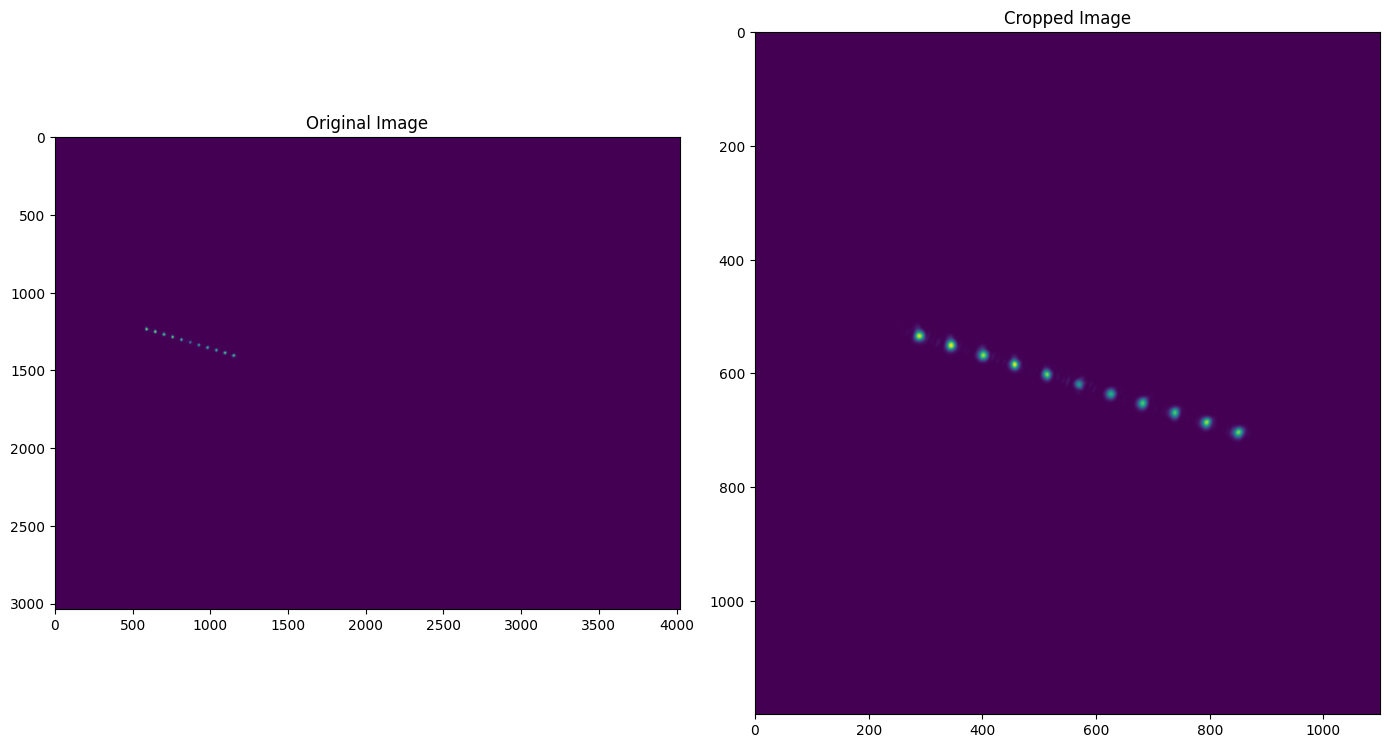

In [66]:
cropped_image = image[700:1900, 300:1400]
print("Max pixel count in cropped image", np.max(cropped_image))

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[1].imshow(cropped_image)
axes[1].set_title("Cropped Image")
plt.tight_layout()
plt.show()

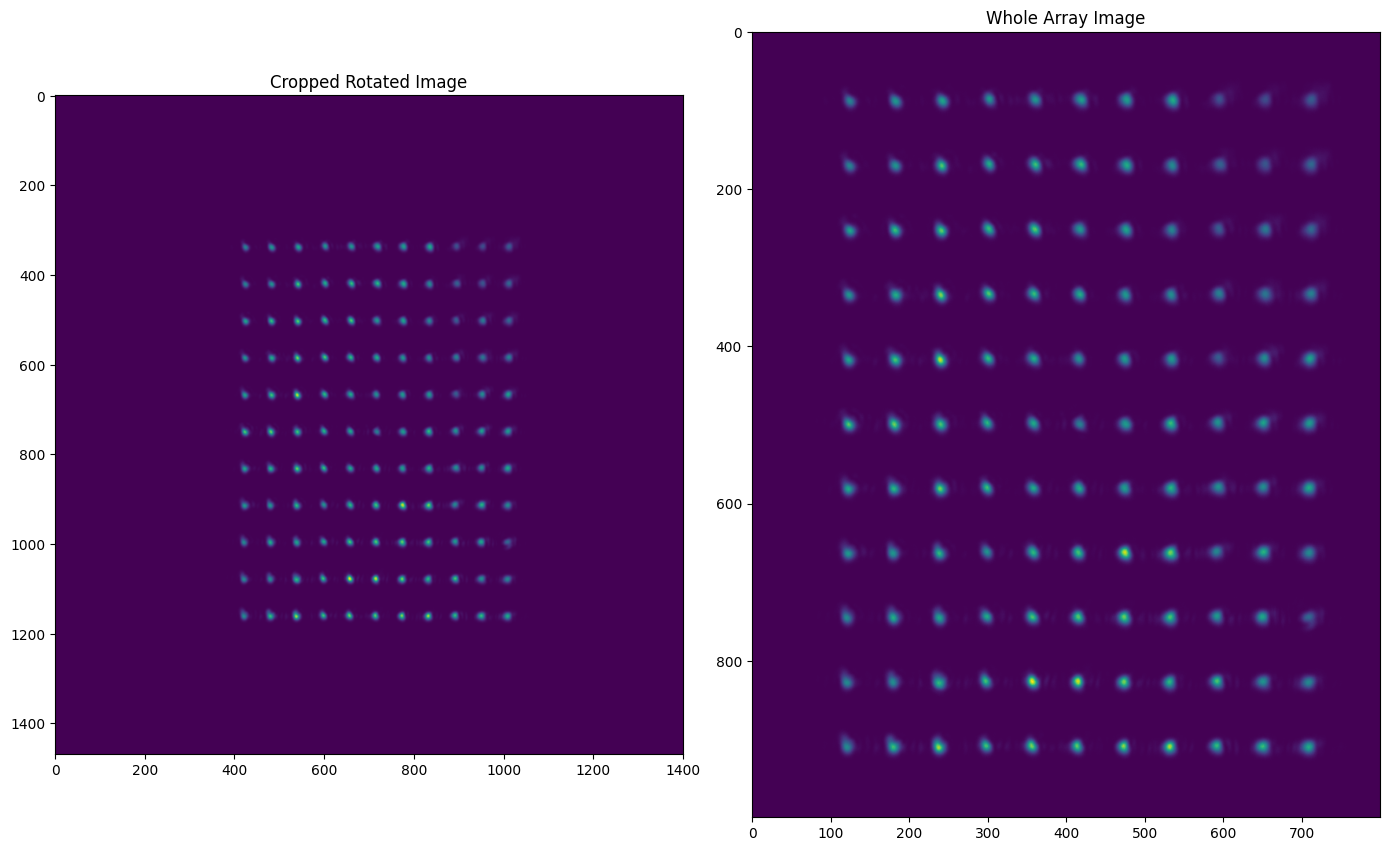

In [7]:
rotated_cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
whole_array_image = rotated_cropped_image[250:1250, 300:1100]

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes[0].imshow(rotated_cropped_image)
axes[0].set_title("Cropped Rotated Image")
axes[1].imshow(whole_array_image)
axes[1].set_title("Whole Array Image")
plt.tight_layout()
plt.show()

In [8]:
whole_array_destination_path = "./output/small_array"
np.save(os.path.join(whole_array_destination_path, f"whole_array"), whole_array_image)

## Multiple Exposure Time Imaging

In [ ]:
exposure_times = np.array([50, 100, 250, 500, 750, 1500, 5000, 15000, 50000, 150000, 500000, 1000000, 2000000], dtype=np.float32)
light_images = take_multiple_exposures(exposure_times, "./output/small_array/center_spot")

Exposure time 50.0 completed. Maximum pixel value: 34
Exposure time 100.0 completed. Maximum pixel value: 68
Exposure time 250.0 completed. Maximum pixel value: 150
Exposure time 500.0 completed. Maximum pixel value: 255
Exposure time 750.0 completed. Maximum pixel value: 255
Exposure time 1500.0 completed. Maximum pixel value: 255
Exposure time 5000.0 completed. Maximum pixel value: 255
Exposure time 15000.0 completed. Maximum pixel value: 255
Exposure time 50000.0 completed. Maximum pixel value: 255
Exposure time 150000.0 completed. Maximum pixel value: 255
Exposure time 500000.0 completed. Maximum pixel value: 255
Exposure time 1000000.0 completed. Maximum pixel value: 255
Exposure time 2000000.0 completed. Maximum pixel value: 255


In [ ]:
# exposure_times = np.array([50, 100, 250, 500, 750, 1500, 5000, 15000, 50000, 150000, 500000, 1000000, 2000000], dtype=np.float32)
# dark_images = take_multiple_exposures(exposure_times, "./output/small_array/darks")

Exposure time 50.0 completed. Maximum pixel value: 0
Exposure time 100.0 completed. Maximum pixel value: 0
Exposure time 250.0 completed. Maximum pixel value: 0
Exposure time 500.0 completed. Maximum pixel value: 0
Exposure time 750.0 completed. Maximum pixel value: 0
Exposure time 1500.0 completed. Maximum pixel value: 0
Exposure time 5000.0 completed. Maximum pixel value: 3
Exposure time 15000.0 completed. Maximum pixel value: 10
Exposure time 50000.0 completed. Maximum pixel value: 30
Exposure time 150000.0 completed. Maximum pixel value: 90
Exposure time 500000.0 completed. Maximum pixel value: 230
Exposure time 1000000.0 completed. Maximum pixel value: 255
Exposure time 2000000.0 completed. Maximum pixel value: 255


## Middle Line Analysis 

198


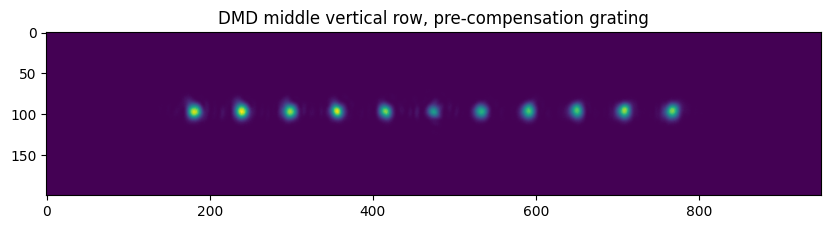

In [ ]:
rotated_cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
# line_image = ndimage.rotate(line_image, 90, reshape=True)
line_image = rotated_cropped_image[650:850, 250:1200]

print(np.max(line_image))
plt.figure(figsize=(10,10))
plt.imshow(line_image)
plt.title("DMD middle vertical row, pre-compensation grating")
plt.show()

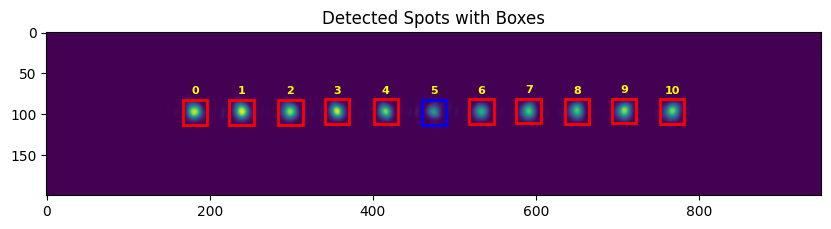

In [69]:
draw_boundaries_around_spots_1d(line_image, 11, axis=1, plot_info="indices")

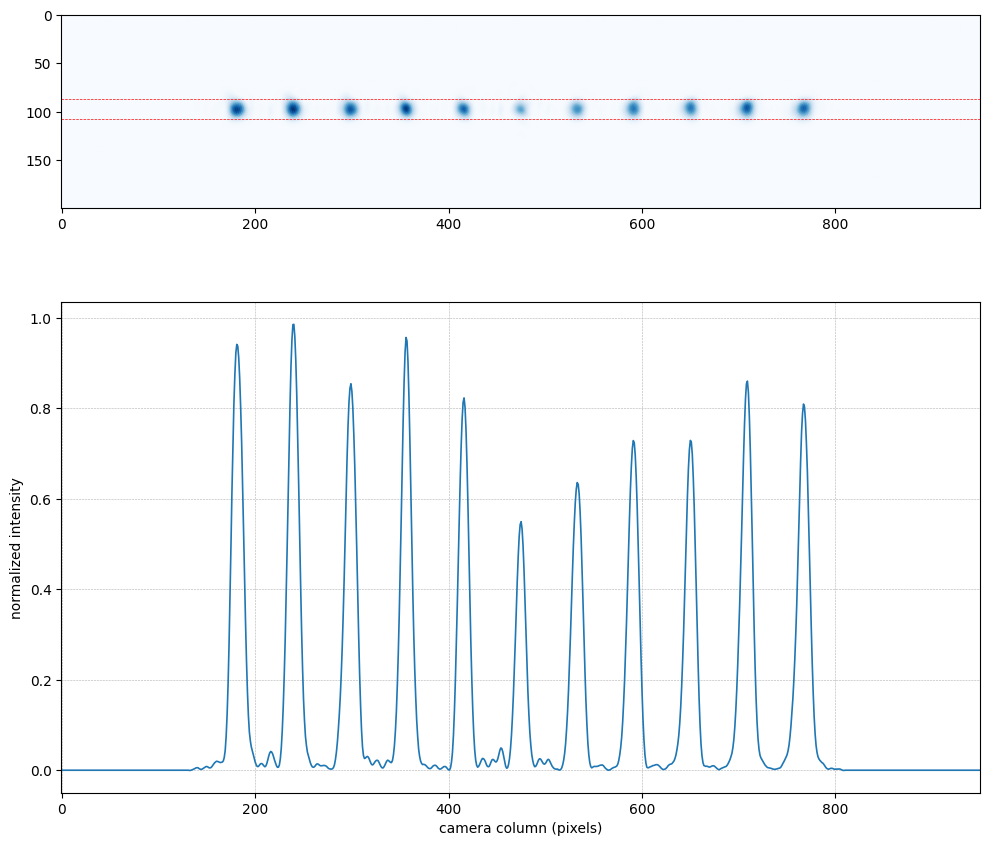

In [70]:

# ---------- choose a band around the bright row ----------
# (automatic): find row with maximum total signal and average ±N rows
N = 10          # half-width in pixels
get_band_profile(line_image, [line_image], half_width=N, logscale=False)

## Analyzing Data 

### First, load data from saved images

In [5]:
dark_images = []
t_unsorted = np.zeros_like(exposure_times)
images_dir = f"./output/small_array/darks"

for i, filename in enumerate(os.listdir(images_dir)):
    if filename.endswith(".npy"):
        exposure_time = int(filename.split("_")[1].split(".")[0])
        image = np.load(os.path.join(images_dir, filename))
        
        dark_images.append(image)
        t_unsorted[i] = exposure_time
        
        if exposure_time not in exposure_times:
            raise ValueError(f"Exposure time {exposure_time} not found in exposure_times array.")
    else:
        continue
indices = np.argsort(t_unsorted)
dark_images = [np.array(dark_images[i]) for i in indices]


In [71]:
images_dir = f"./output/small_array/center_spot"
lights_imgs = []
t_unsorted = np.zeros_like(exposure_times)
for i, filename in enumerate(os.listdir(images_dir)):
    if filename.endswith(".npy"):
        exposure_time = int(filename.split("_")[1].split(".")[0])
        image = np.load(os.path.join(images_dir, filename))
        
        lights_imgs.append(image)
        t_unsorted[i] = exposure_time
        
        if exposure_time not in exposure_times:
            raise ValueError(f"Exposure time {exposure_time} not found in exposure_times array.")
    else:
        continue
# take images
indices = np.argsort(t_unsorted)

lights_imgs = [np.array(lights_imgs[i]) for i in indices]
imgs_minus_dark = [img - dark for img, dark in zip(lights_imgs, dark_images)]
imgs = [np.clip(img, 0, None) for img in imgs_minus_dark]


In [12]:
# load original whole array image
whole_array_img_path = "./output/small_array/whole_array.npy"
whole_array_image = np.load(whole_array_img_path)

### Cropping for the Middle Line

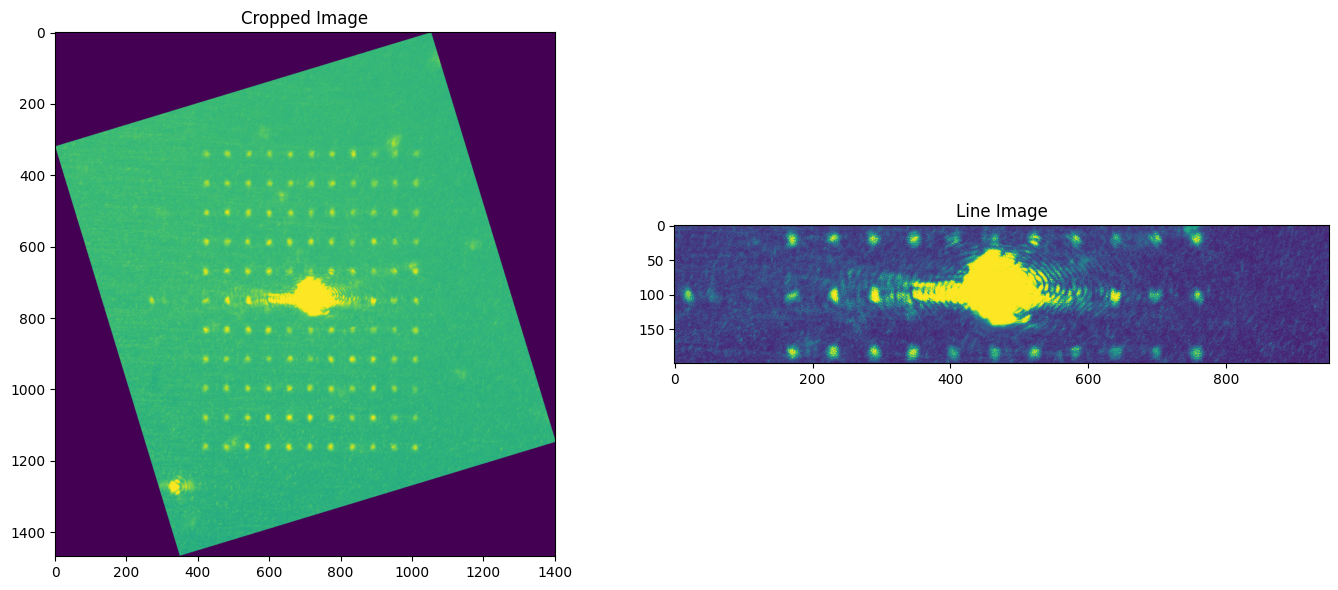

In [72]:
last_image = imgs[-1]

cropped_image = last_image[700:1900, 300:1400]
cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
line_image = cropped_image[650:850, 250:1200]
# Uncomment the next two lines for a vertical row
# line_image = cropped_image[250:1250, 600:850]
# line_image = ndimage.rotate(line_image, 90, reshape=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cropped_image)
axes[0].set_title("Cropped Image")
axes[1].imshow(line_image)
axes[1].set_title("Line Image")
plt.tight_layout()
plt.show()

# Cropping for the Whole Array

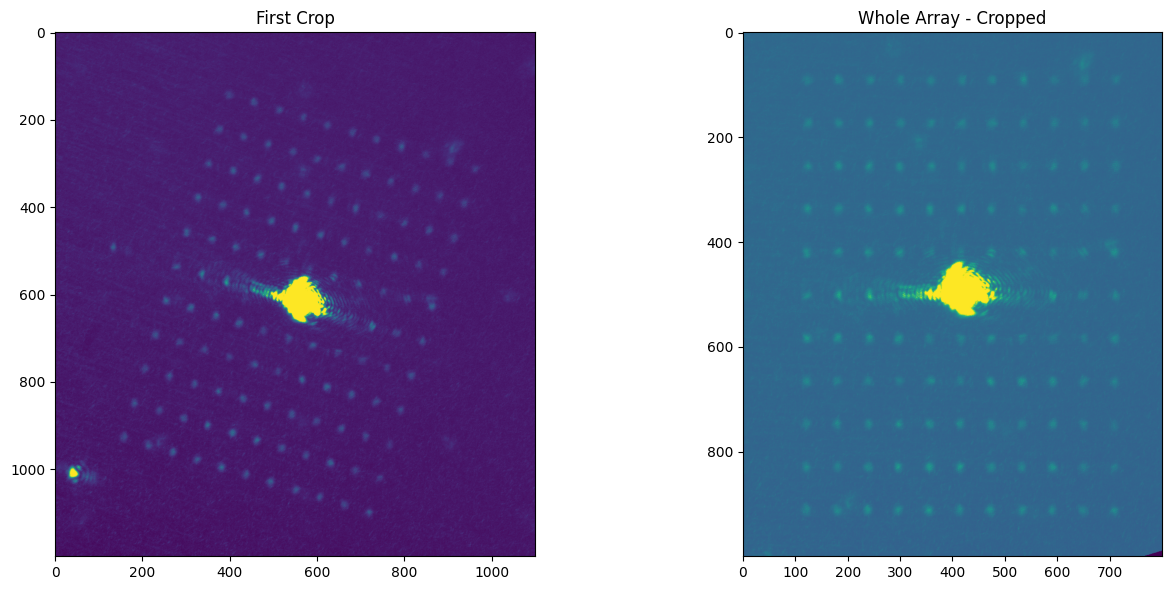

In [10]:
last_image = imgs[-2]
cropped_image = last_image[700:1900, 300:1400]
rotated_cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
whole_array_image = rotated_cropped_image[250:1250, 300:1100]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cropped_image)
axes[0].set_title("First Crop")
axes[1].imshow(whole_array_image)
axes[1].set_title("Whole Array - Cropped")
plt.tight_layout()
plt.show()

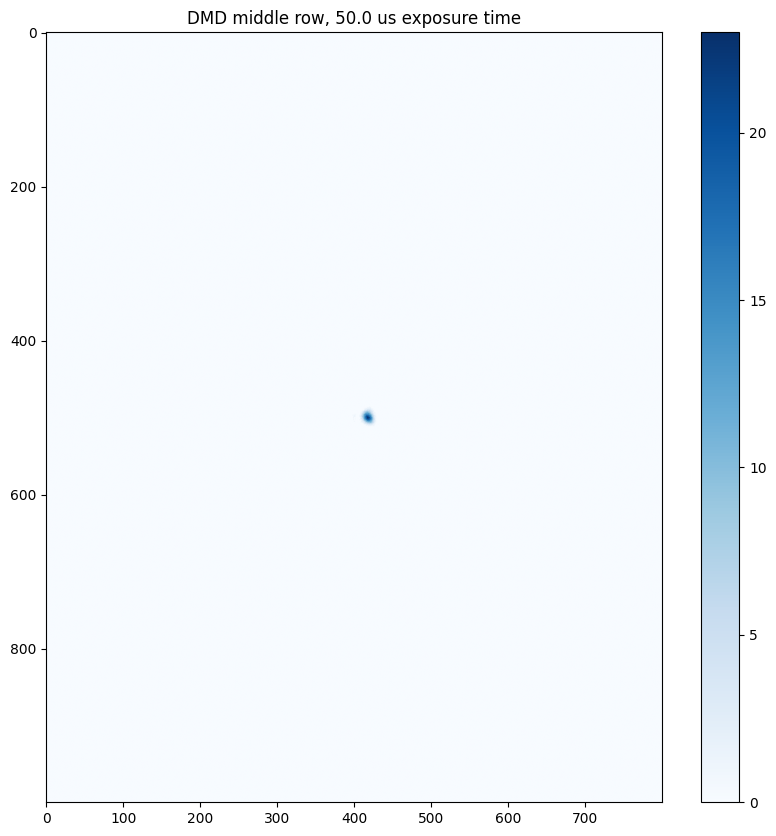

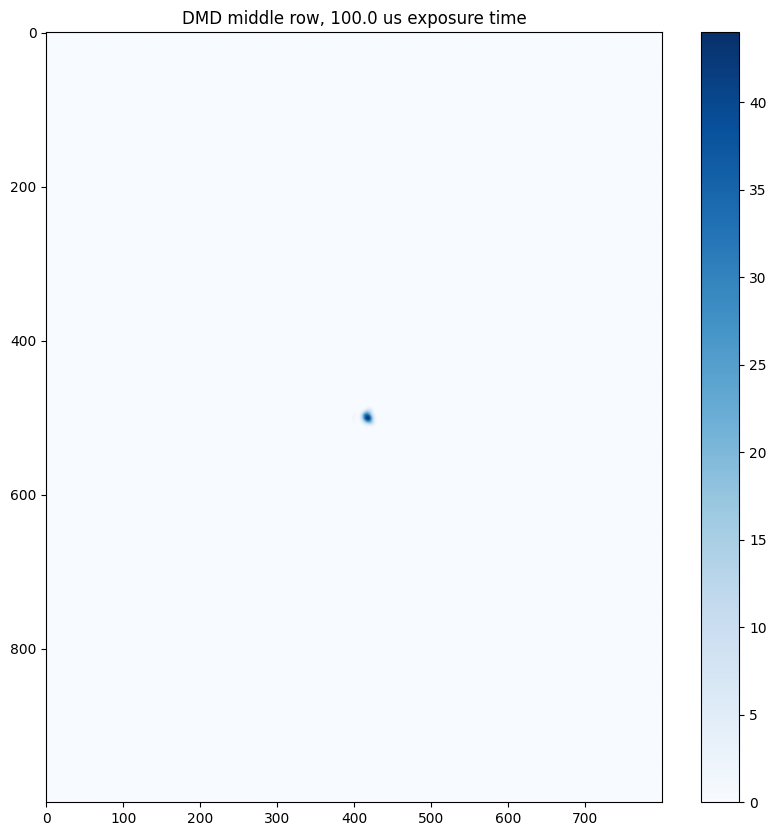

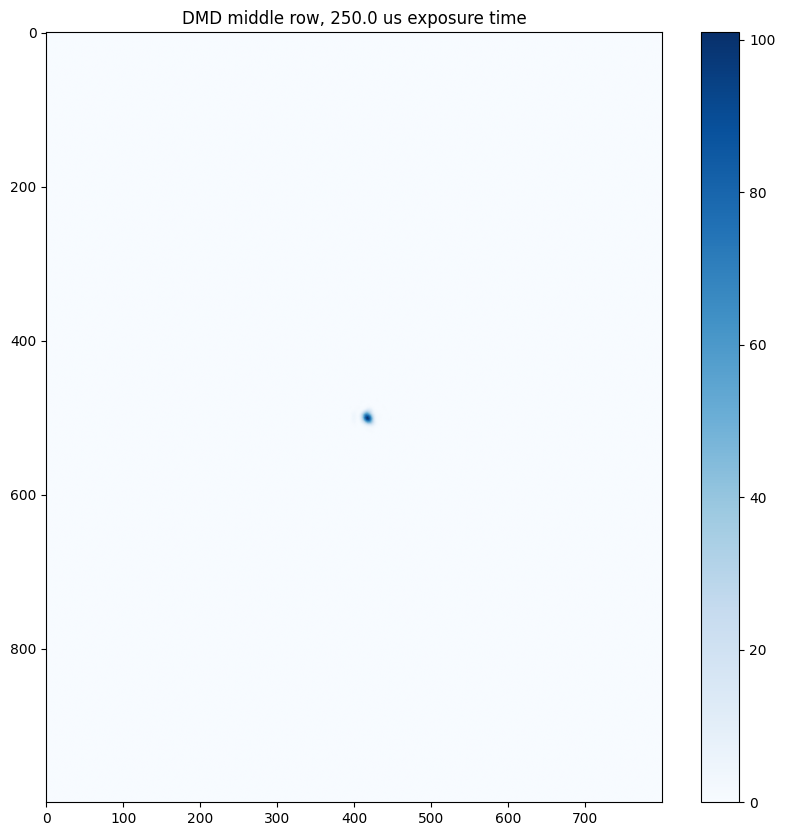

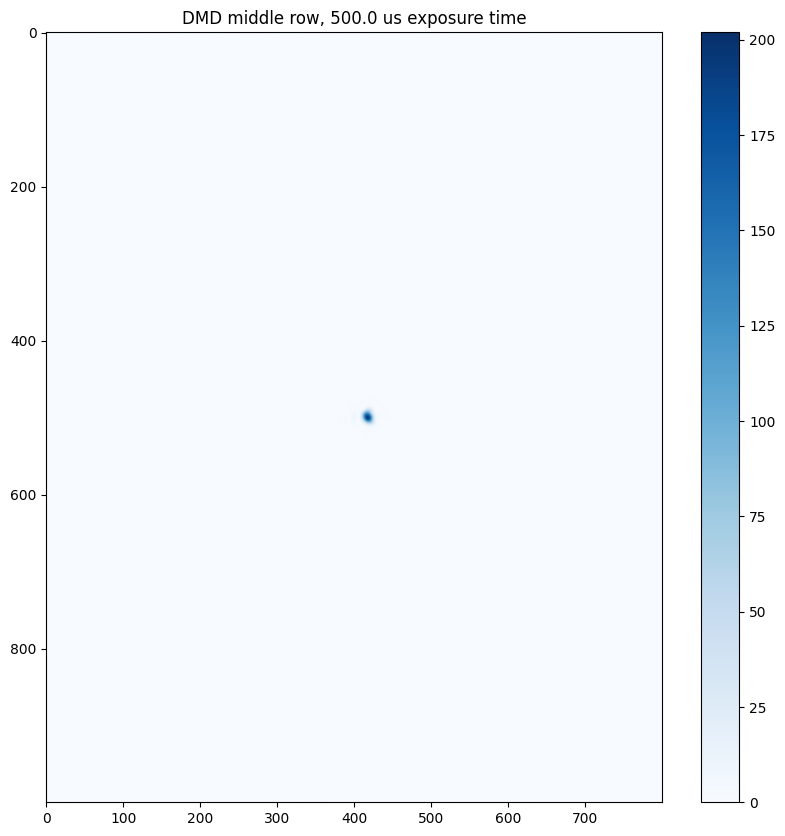

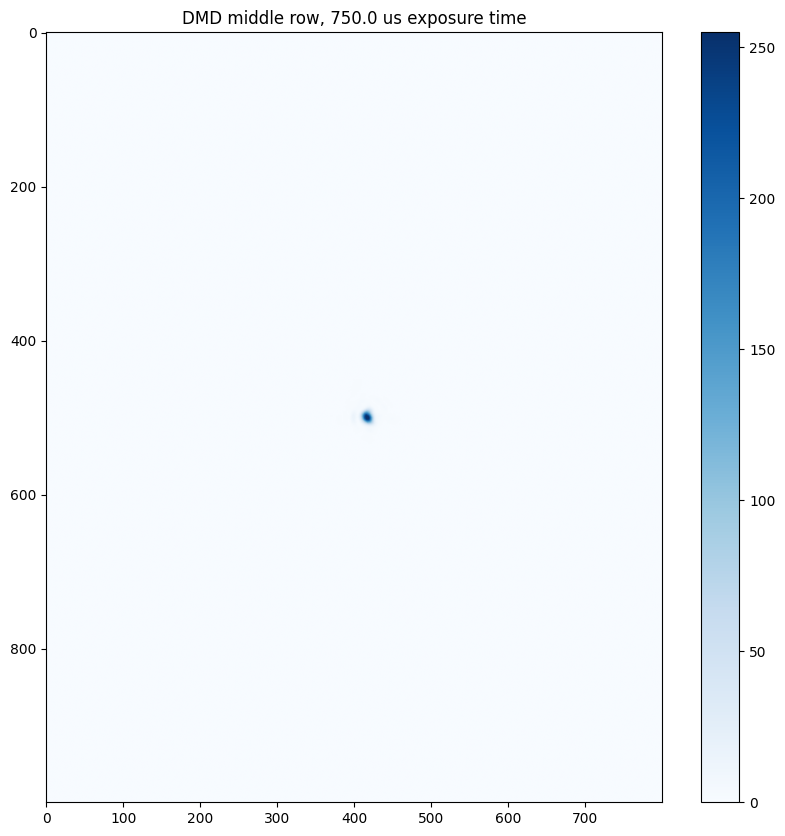

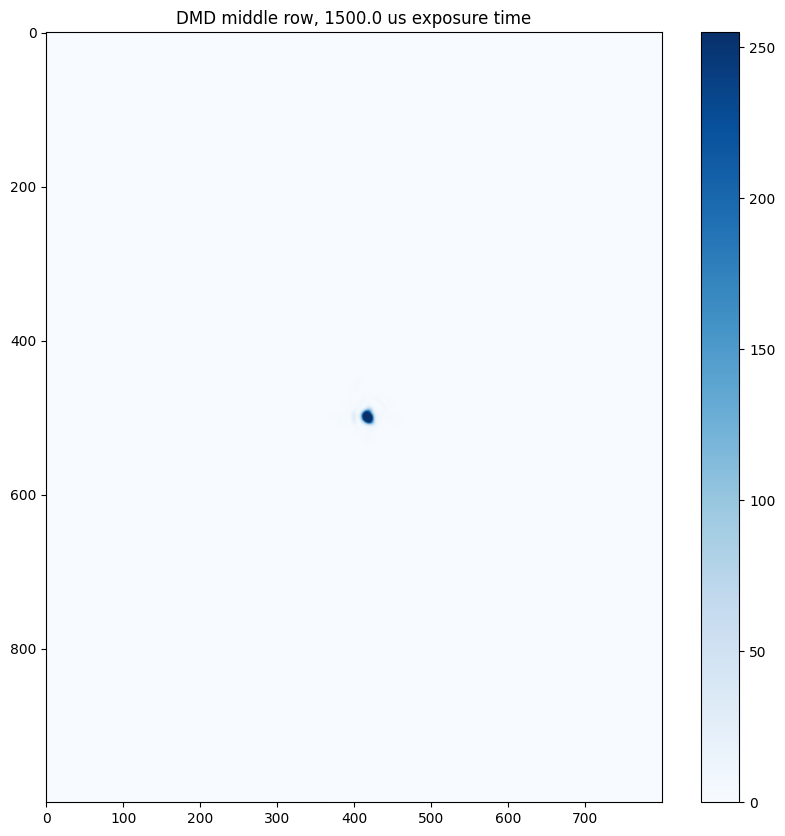

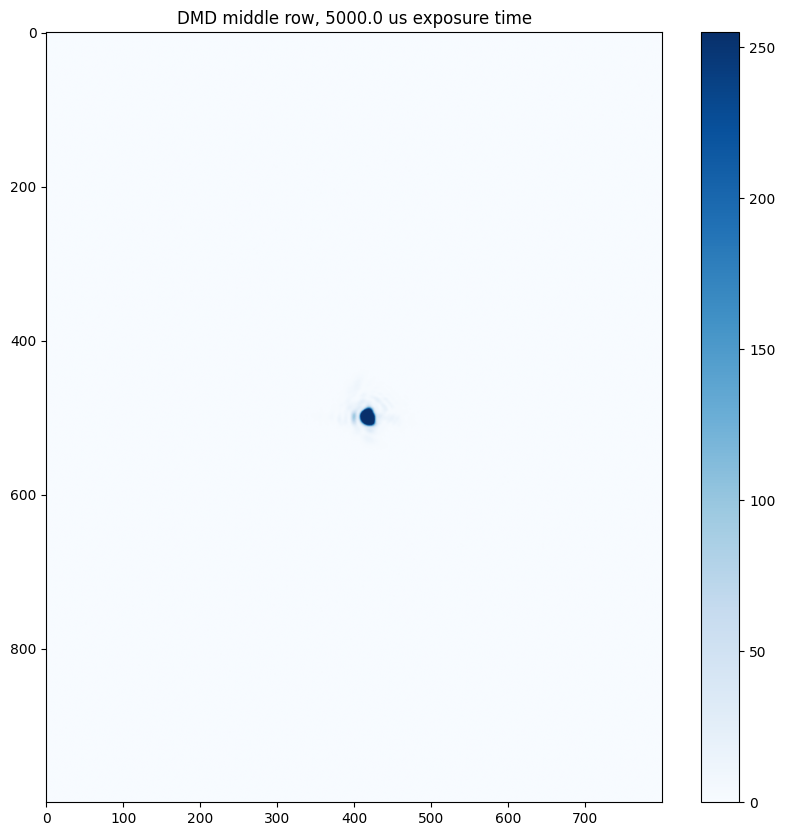

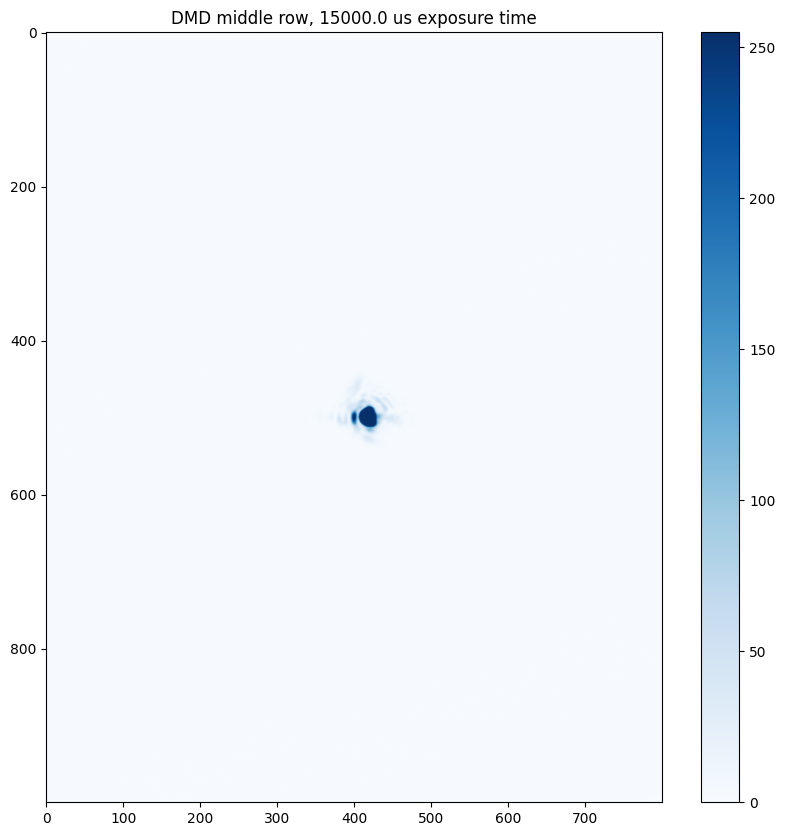

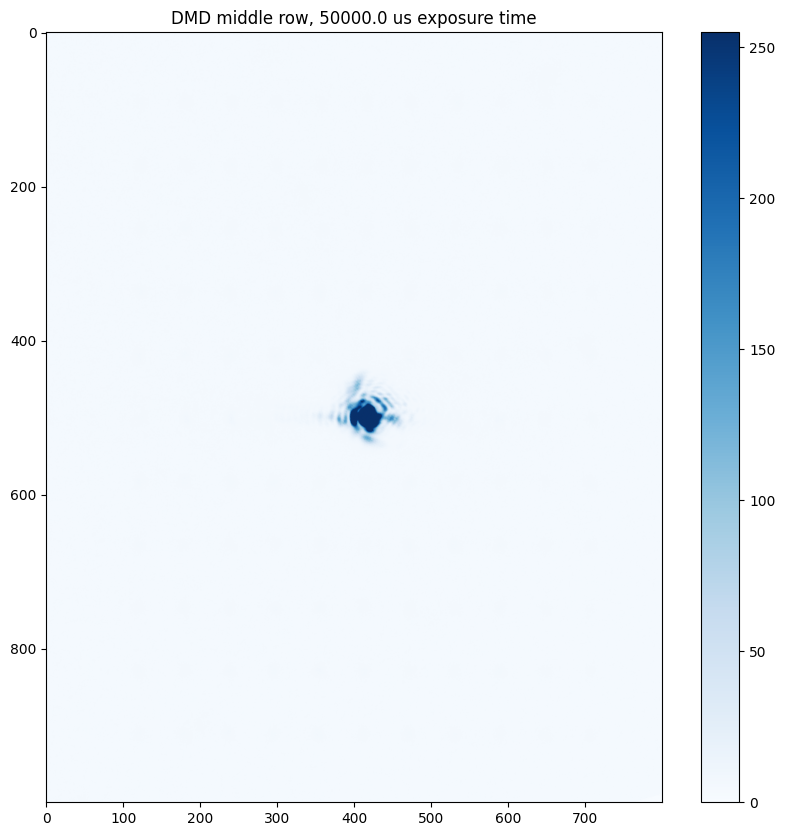

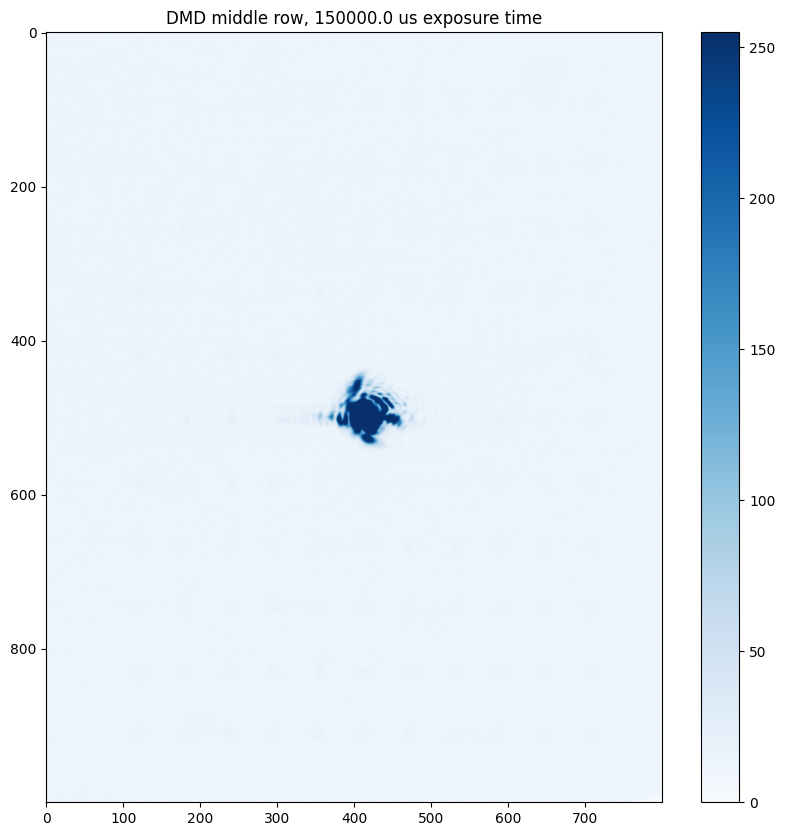

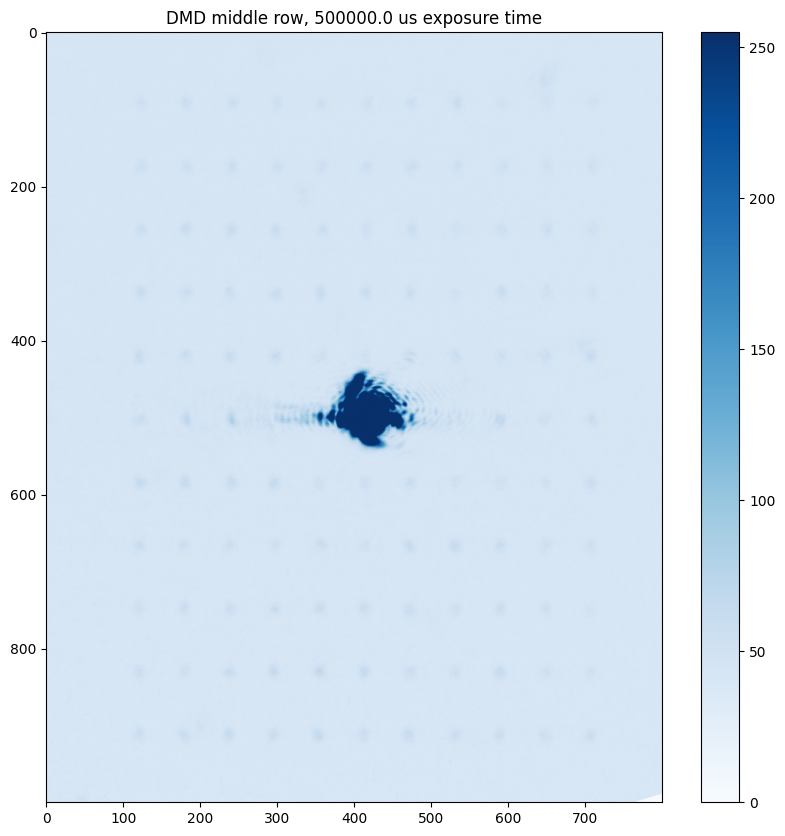

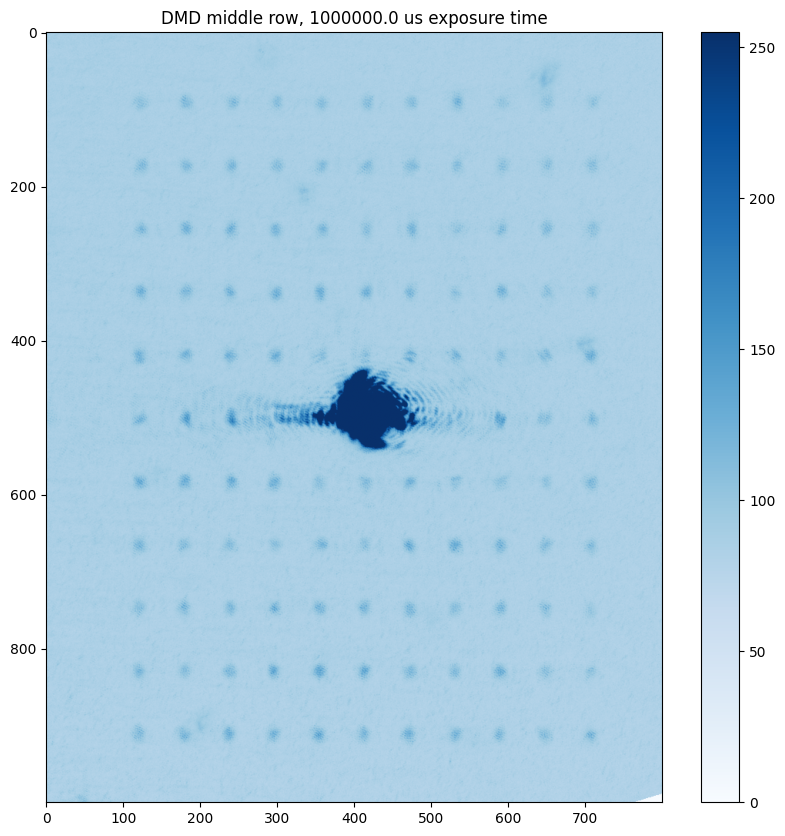

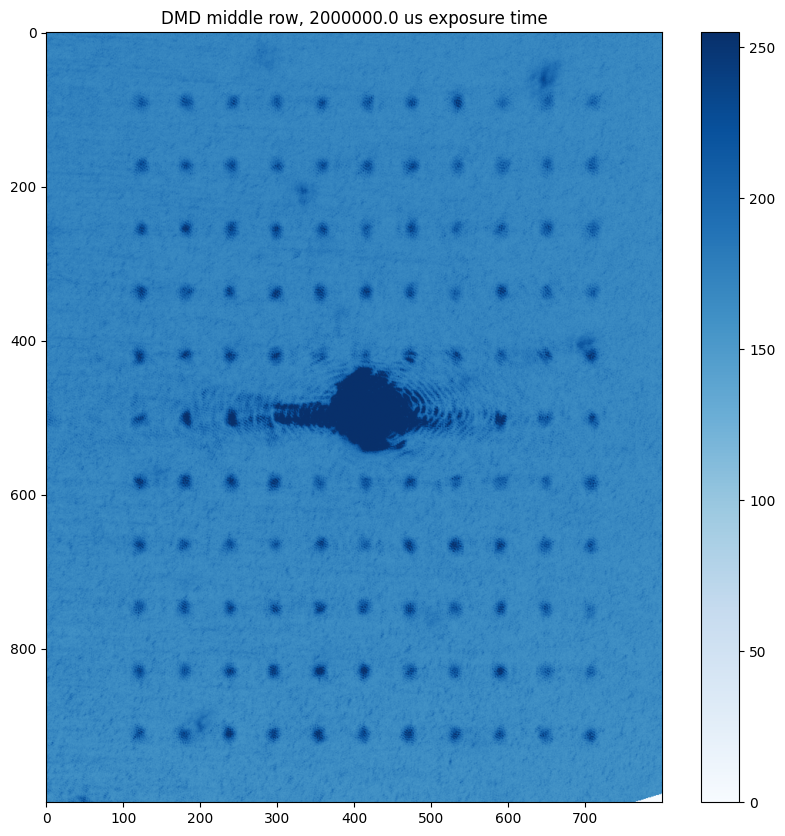

In [13]:
array_imgs_list = []
for image in imgs:
    cropped_image = image[700:1900, 300:1400]
    rotated_cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
    whole_array = rotated_cropped_image[250:1250, 300:1100]
    array_imgs_list.append(whole_array)

for i, img in enumerate(array_imgs_list):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='Blues')
    plt.title(f"DMD middle row, {exposure_times[i]} us exposure time")
    plt.colorbar()
    plt.show()

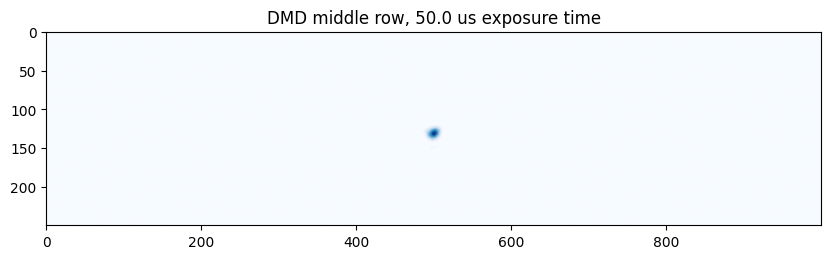

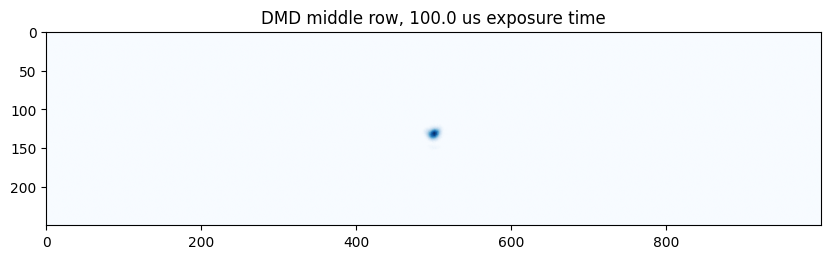

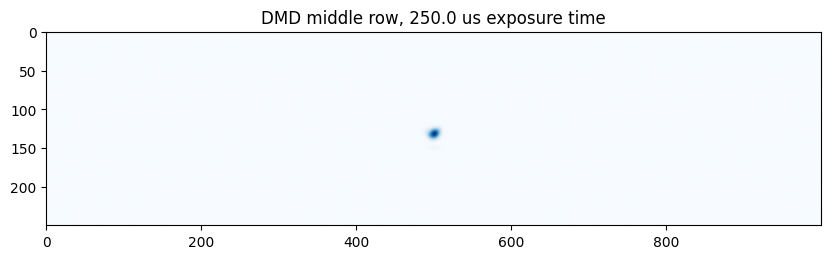

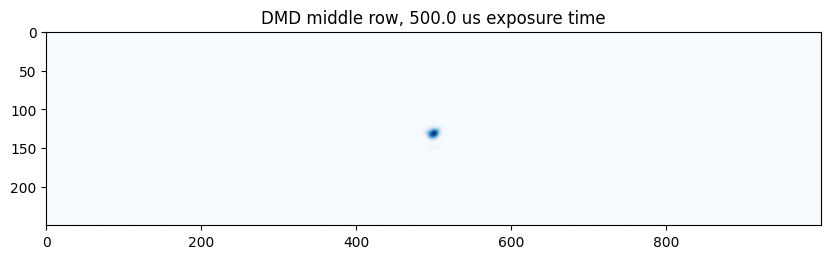

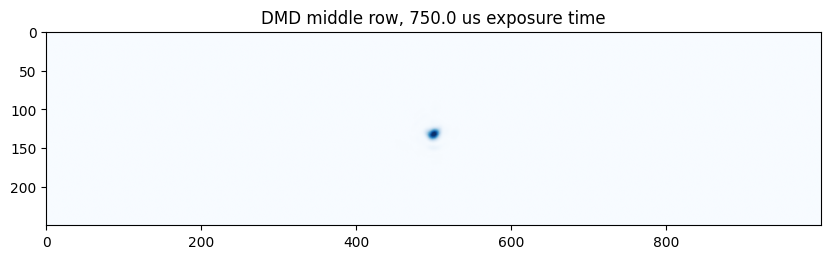

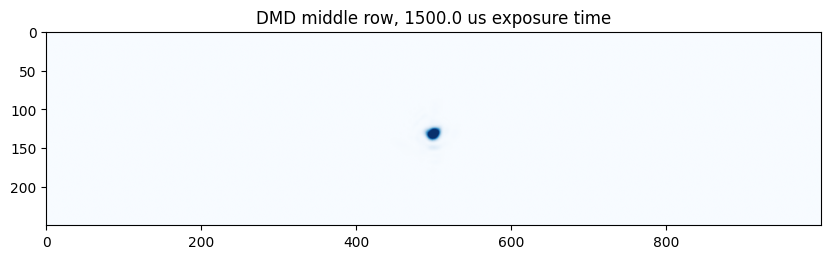

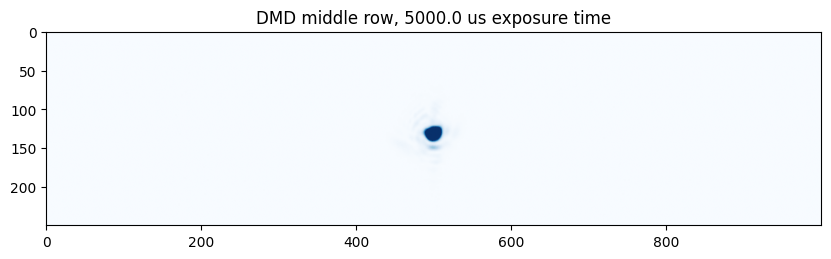

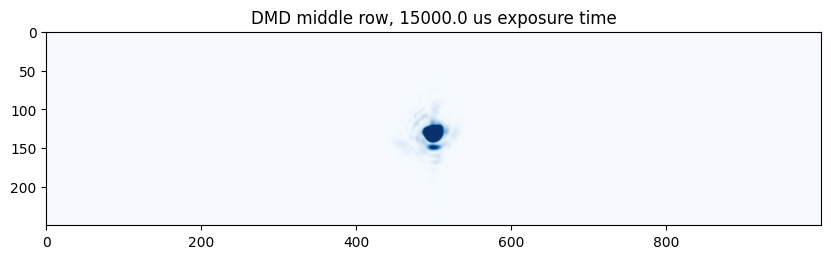

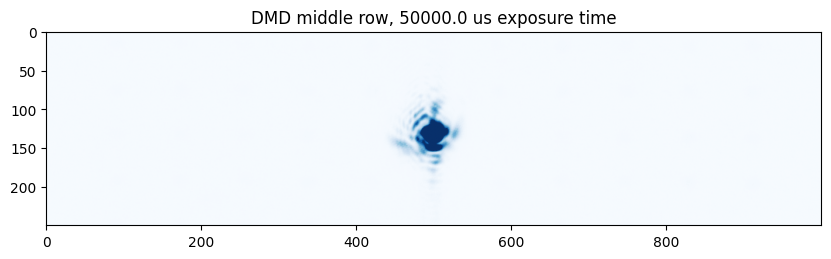

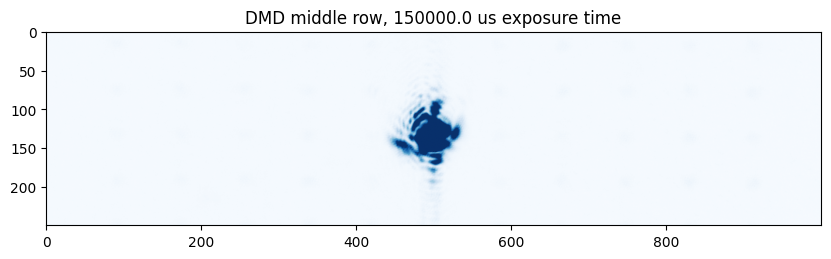

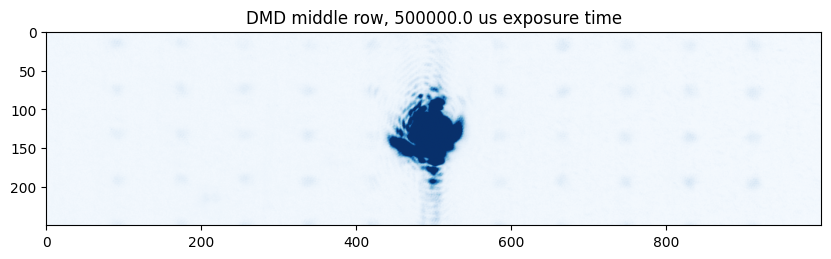

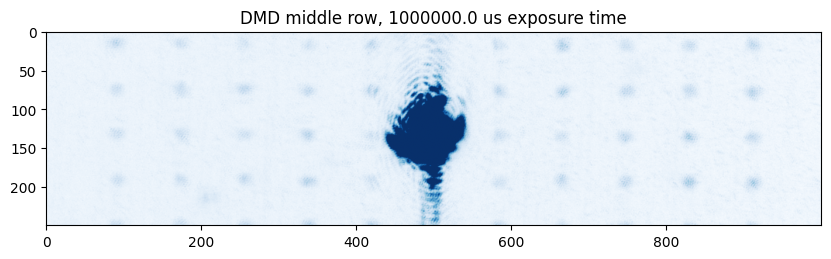

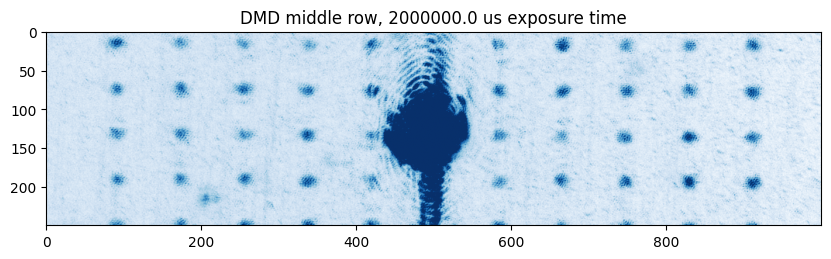

In [75]:
bands_list = []
for image in imgs:

    # horiztonal band
    # cropped_image = image[700:1900, 300:1400]
    # cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
    # line_image = cropped_image[650:850, 250:1200]

    # vertical band
    cropped_image = image[700:1900, 300:1400]
    cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
    line_image = cropped_image[250:1250, 600:850]
    line_image = ndimage.rotate(line_image, 90, reshape=True) 

    bands_list.append(line_image)

for i, band in enumerate(bands_list):
    plt.figure(figsize=(10, 10))
    plt.imshow(band, cmap='Blues')
    plt.title(f"DMD middle row, {exposure_times[i]} us exposure time")
    plt.show()

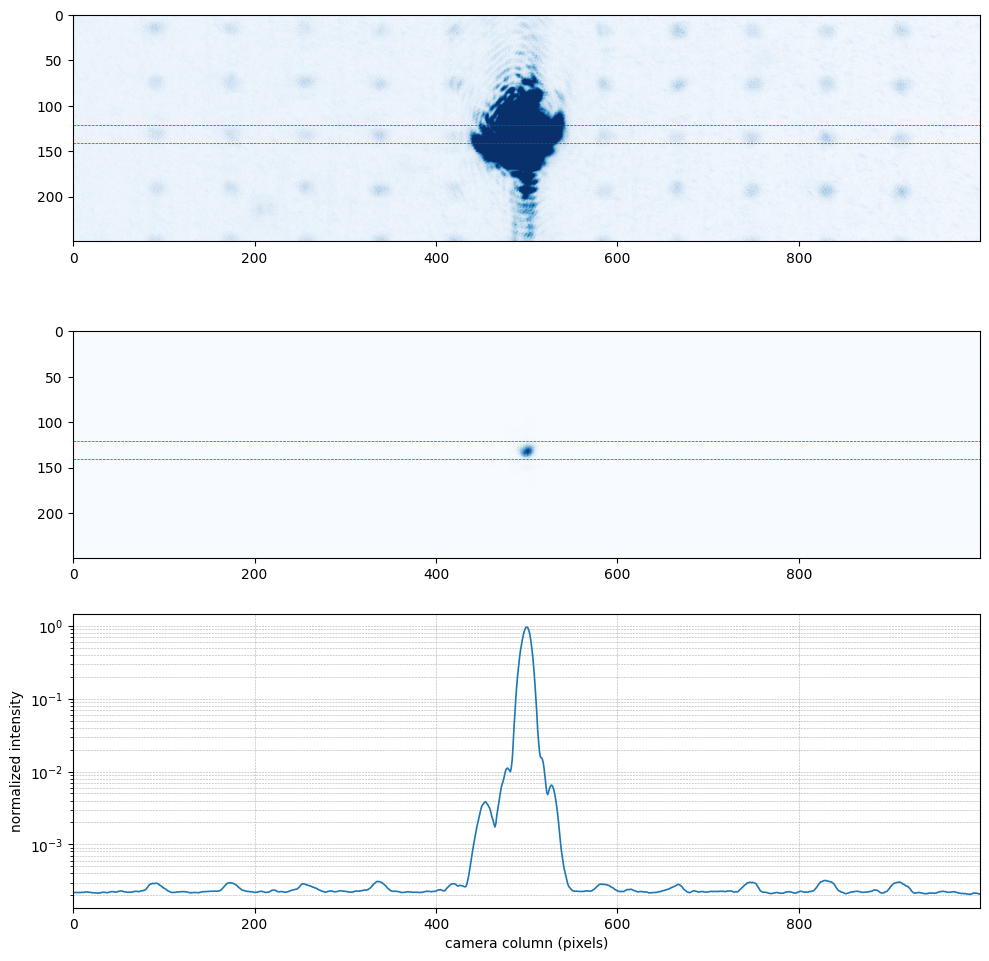

In [76]:
hdr_merged_image = hdr_merge(bands_list, exposure_times)
get_band_profile(hdr_merged_image, [bands_list[-2], hdr_merged_image], half_width=10, logscale=True)

## Full Array Analysis

253


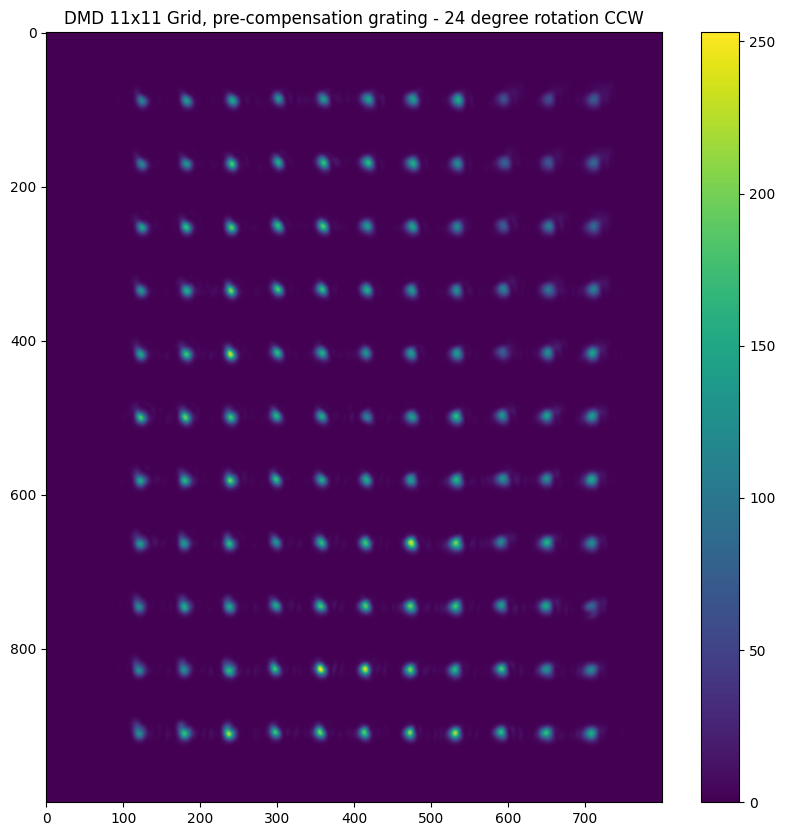

In [9]:
# rotated_image = ndimage.rotate(cropped_image, 24)

print(np.max(whole_array_image))
plt.figure(figsize=(10,10))
plt.imshow(whole_array_image)
plt.colorbar()
plt.title("DMD 11x11 Grid, pre-compensation grating - 24 degree rotation CCW")
plt.show()

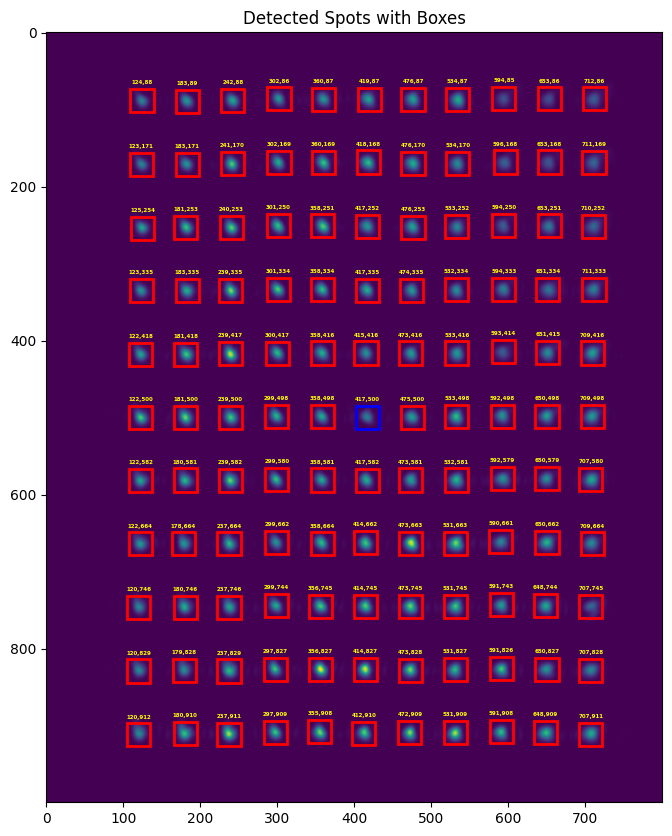

In [10]:
draw_boundaries_around_spots_2d(whole_array_image, 11, plot_info="coords")

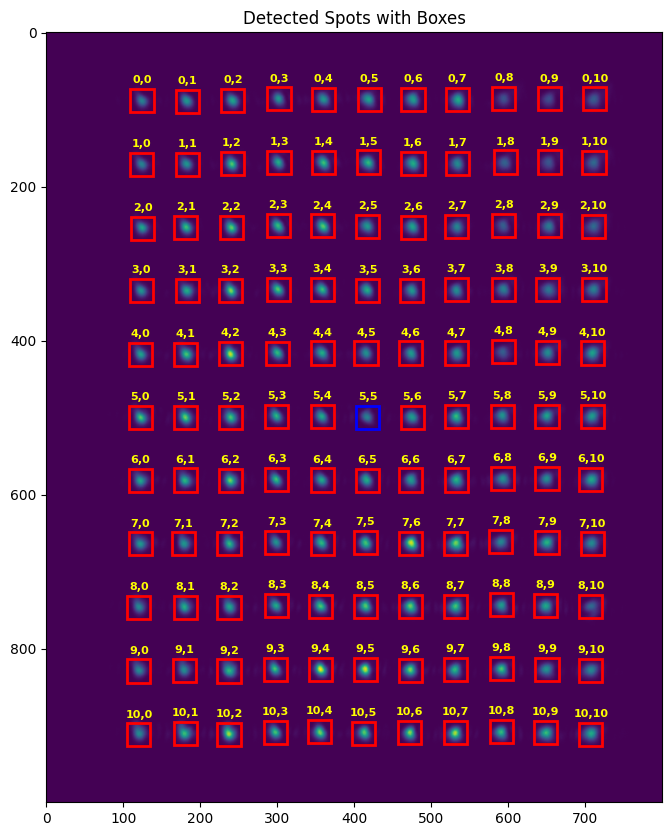

In [11]:
spot_indices = find_spots(whole_array_image, 121, threshold=1)
si_2d = get_2d_spot_indices(spot_indices)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(whole_array_image, cmap='viridis')
box_size = 15  # Half-width of the box (adjust as needed)

for row in range(si_2d.shape[0]):
    for col in range(si_2d.shape[1]):
        spot_y, spot_x = si_2d[row, col]
        edgecolor = "blue" if row == 5 and col == 5 else "red"
        rect = patches.Rectangle(
        (spot_x - box_size, spot_y - box_size),  # (x, y) of lower left
        2 * box_size, 2 * box_size,              # width, height
        linewidth=2, edgecolor=edgecolor, facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            spot_x, spot_y - box_size - 5, f"{row},{col}",
            color='yellow', fontsize=8, ha='center', va='bottom', weight='bold'
        )

plt.title("Detected Spots with Boxes")
plt.show()


Unit Testing 

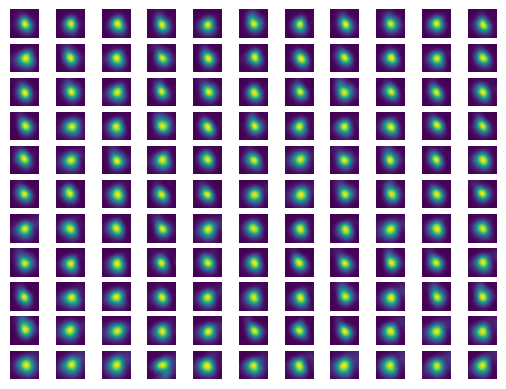

In [12]:
# Reshape axes to 2D for 10x10 grid and plot each spot
fig, axes = plt.subplots(11, 11)
for idx, (spot_y, spot_x) in enumerate(spot_indices):
    row, col = divmod(idx, 11)
    region = whole_array_image[spot_y - box_size:spot_y + box_size, spot_x - box_size:spot_x + box_size]
    axes[row, col].imshow(region, cmap='viridis')
    axes[row, col].axis('off')
plt.show()

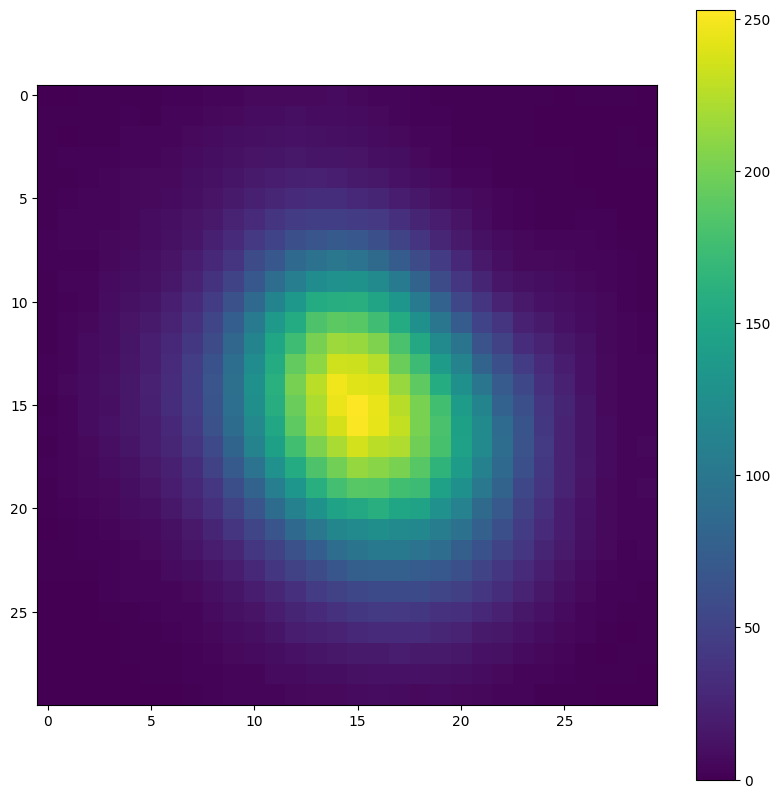

36051


In [13]:
spot_x, spot_y = spot_indices[0][1], spot_indices[0][0]
border_size = 15
first_spot_img = whole_array_image[spot_y-border_size:spot_y+border_size, spot_x-border_size:spot_x+border_size]
plt.figure(figsize=(10,10))
plt.imshow(first_spot_img)
plt.colorbar()
plt.show()
print(np.sum(first_spot_img))

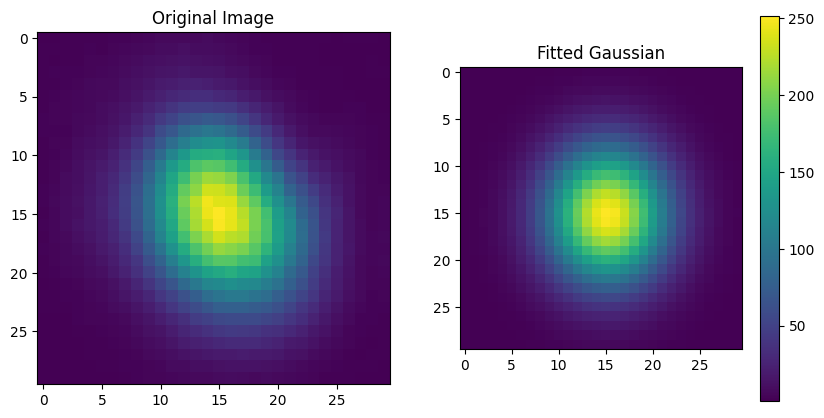

Fitted parameters:
A: 250.92
x0: 15.19
y0: 15.23
sigma_x: 4.44
sigma_y: 5.02
C: 1.22
Beam waist (x): 8.87 pixels = 1.64e+02 microns
Beam waist (y): 10.03 pixels = 1.86e+02 microns


In [14]:
params, beam_waist_x, beam_waist_y = estimate_gaussian(first_spot_img, intensity_guess=100, plot_image=True, print_output=True)

In [16]:
intensity_data, bw_data = compute_array_uniformity(whole_array_image, 121)

In [17]:
normalized_data = []
for attrb in intensity_data:
    normalized_data.append(attrb/np.mean(attrb))
for attrb in bw_data:
    center_data = attrb[5, 5]
    normalized_data.append(attrb/center_data)

gi_norm, ti_norm, wx_norm, wy_norm = normalized_data

In [18]:
bw_x_center = bw_data[0][5, 5]
bw_y_center = bw_data[1][5, 5]
print(f"Beam waist (x-direction) of the center spot: {bw_x_center}")
print(f"Beam waist (y-direction) of the center spot: {bw_y_center}")

Beam waist (x-direction) of the center spot: 9.272419108106243
Beam waist (y-direction) of the center spot: 9.922309445748887


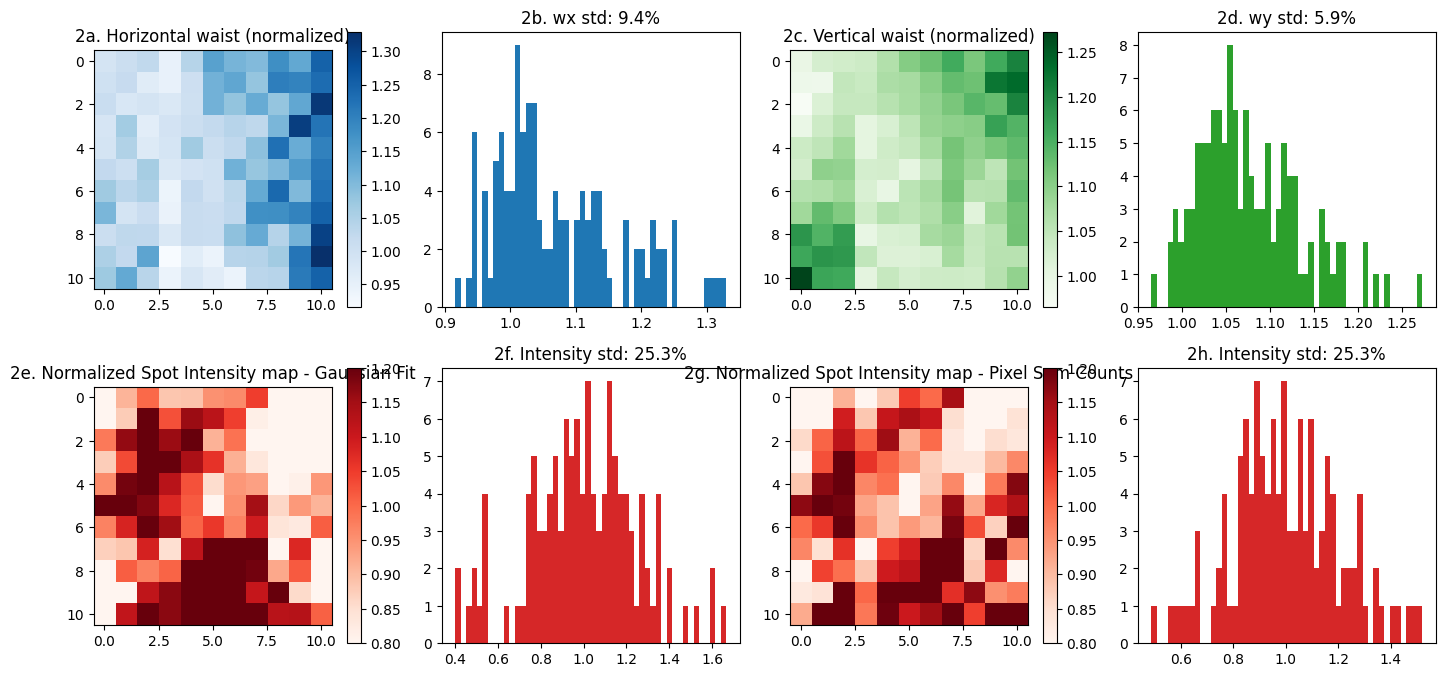

In [19]:
# --- Plotting ---
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(3, 4)

# 2a: wx map
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(wx_norm, cmap='Blues')
plt.colorbar(im0, ax=ax0)
ax0.set_title("2a. Horizontal waist (normalized)")

# 2b: wx histogram
ax1 = fig.add_subplot(gs[0, 1])
ax1.hist(wx_norm.flatten(), bins=50, color='tab:blue')
ax1.set_title(f"2b. wx std: {np.std(wx_norm)*100:.1f}%")

# 2c: wy map
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(wy_norm, cmap='Greens')
plt.colorbar(im2, ax=ax2)
ax2.set_title("2c. Vertical waist (normalized)")

# 2d: wy histogram
ax3 = fig.add_subplot(gs[0, 3])
ax3.hist(wy_norm.flatten(), bins=50, color='tab:green')
ax3.set_title(f"2d. wy std: {np.std(wy_norm)*100:.1f}%")

# 2e: Intensity map
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(gi_norm, cmap='Reds', vmin=0.8, vmax=1.2)
plt.colorbar(im4, ax=ax4)
ax4.set_title("2e. Normalized Spot Intensity map - Gaussian Fit")

# 2f: Intensity histogram
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(gi_norm.flatten(), bins=50, color='tab:red')
ax5.set_title(f"2f. Intensity std: {np.std(gi_norm)*100:.1f}%")

# 2e: Intensity map - pixel sum counts
ax4 = fig.add_subplot(gs[1, 2])
im4 = ax4.imshow(ti_norm, cmap='Reds', vmin=0.8, vmax=1.2)
plt.colorbar(im4, ax=ax4)
ax4.set_title("2g. Normalized Spot Intensity map - Pixel Sum Counts")

# 2f: Intensity histogram - pixel sum counts
ax5 = fig.add_subplot(gs[1, 3])
ax5.hist(ti_norm.flatten(), bins=50, color='tab:red')
ax5.set_title(f"2h. Intensity std: {np.std(gi_norm)*100:.1f}%") 

plt.tight_layout()
plt.show()

## Analyzing Crosstalk for spots, $(\Delta i, \Delta j)$ from center

Final Image assembled


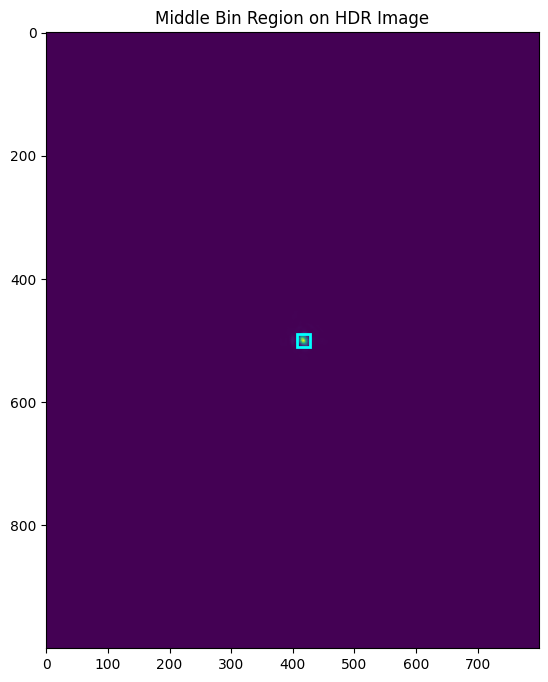

middle bin intensity 0.40400001406669617


In [20]:
bin_size_hf = math.ceil(max(bw_x_center, bw_y_center))
R_max = 2
crosstalk_I_ratio, crosstalk_db = compute_nearest_neighbor_crosstalk(5, 5, 11, whole_array_image, array_imgs_list, np.array(exposure_times, dtype=np.float32), bin_size_hf, R_max)
nn_crosstalk = (crosstalk_db[1, 2] + crosstalk_db[2, 1] + crosstalk_db[3, 2] + crosstalk_db[2, 3])/4


In [21]:
crosstalk_I_ratio, crosstalk_db

(array([[0.00031436, 0.00031312, 0.00031188, 0.00030817, 0.00028342],
        [0.00033168, 0.00030446, 0.00029827, 0.00033911, 0.00031188],
        [0.00052723, 0.00244224, 0.        , 0.00127063, 0.00032178],
        [0.00031436, 0.00029579, 0.0002896 , 0.00031436, 0.00030322],
        [0.00029827, 0.00031436, 0.00028837, 0.00031312, 0.00031436]]),
 array([[-35.02577637, -35.04290845, -35.06010839, -35.11212021,
         -35.47575898],
        [-34.79276576, -35.1647625 , -35.25394331, -34.69660828,
         -35.06010839],
        [-32.78001763, -26.12210931,   0.        , -28.9598189 ,
         -34.92438027],
        [-35.02577637, -35.29013473, -35.38195507, -35.02577637,
         -35.18245286],
        [-35.25394331, -35.02577637, -35.40055457, -35.04290845,
         -35.02577637]]))

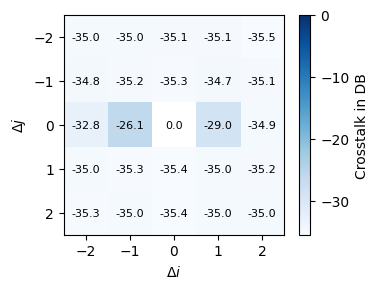

Average nearest neighbor crosstalk in dB: -31.429456644560105
-35.2539433052519
-26.1221093059389
-35.38195506500553
-28.959818902044084


In [22]:
# plot results in an rxr grid

fig, ax = plt.subplots(figsize=(4,3))
# Mask the center entry (middle spot) so it doesn't show in the colormap
masked_crosstalk_db = np.ma.array(crosstalk_db, mask=False)
center_idx = R_max  # for a (2*R_max+1)x(2*R_max+1) array, center is at (R_max, R_max)
masked_crosstalk_db[center_idx, center_idx] = np.ma.masked

# Update the image with the masked array
im = ax.imshow(
    crosstalk_db,
    cmap='Blues',
    extent=[-R_max - 0.5, R_max + 0.5, R_max + 0.5, -R_max - 0.5]  # y axis reversed for imshow
)
im.set_data(masked_crosstalk_db)

ax.set_xlabel(r'$\Delta i$')
ax.set_ylabel(r'$\Delta j$')
ax.set_xticks(range(-R_max, R_max + 1))
ax.set_yticks(range(-R_max, R_max + 1))


for i in range(-R_max, R_max+1):
    for j in range(-R_max, R_max+1):
        ax.text(i, j, f'{np.round(crosstalk_db[j+R_max,i+R_max], 1):.1f}',
                ha='center', va='center', color='black', fontsize=8)
cb = fig.colorbar(im, label="Crosstalk in DB")
plt.tight_layout(); plt.show()

print("Average nearest neighbor crosstalk in dB:", nn_crosstalk)
print(crosstalk_db[1, 2])
print(crosstalk_db[2, 1])
print(crosstalk_db[3, 2])
print(crosstalk_db[2, 3])


### Crosstalk of the entire array

In [23]:
def crop_whole_array(image):
    """
    Takes a raw, uncropped image and returns a cropped version of it displaying the 11x11 grid.

    Args:
        img (_type_): raw image, dimensions 3036x4024
    """
    cropped_image = image[700:1900, 300:1400]
    rotated_cropped_image = ndimage.rotate(cropped_image, 16.9, reshape=True)
    whole_array_image = rotated_cropped_image[250:1250, 300:1100]

    return whole_array_image


In [26]:
crosstalk_I_ratios, crosstalk_DB, average_nn_crosstalk = average_nn_crosstalk_whole_array(
    spot_array_size=11,
    cropping_function=crop_whole_array,
    full_array_img=whole_array_image,
    exposure_times=exposure_times,
    dark_images=dark_images,
    spot_bucket_hw=bin_size_hf,
    r=R_max
)

Working on spot at (row, col): 0, 0
middle bin intesnity is  0.41200000047683716
avg nn crosstalk -30.12755802058502
Working on spot at (row, col): 0, 1
middle bin intesnity is  0.44200000166893005
avg nn crosstalk -28.42530927097283
Working on spot at (row, col): 0, 2
middle bin intesnity is  0.44999998807907104
avg nn crosstalk -28.05457419980496
Working on spot at (row, col): 0, 3
middle bin intesnity is  0.5519999861717224
avg nn crosstalk -28.36691654103524
Working on spot at (row, col): 0, 4
middle bin intesnity is  0.5400000214576721
avg nn crosstalk -29.876077931623602
Working on spot at (row, col): 0, 5
middle bin intesnity is  0.5759999752044678
avg nn crosstalk -30.580701729787496
Working on spot at (row, col): 0, 6
middle bin intesnity is  0.5440000295639038
avg nn crosstalk -28.410488210977093
Working on spot at (row, col): 0, 7
middle bin intesnity is  0.4819999933242798
avg nn crosstalk -28.78747469077757
Working on spot at (row, col): 0, 8
middle bin intesnity is  0.303

In [28]:
np.mean(average_nn_crosstalk)

np.float64(-30.104276857533165)

In [30]:
nn_crosstalk_avg = (crosstalk_DB[1, 2] + crosstalk_DB[2, 1] + crosstalk_DB[3, 2] + crosstalk_DB[2, 3])/4
nn_crosstalk_avg

np.float64(-30.13929047414114)

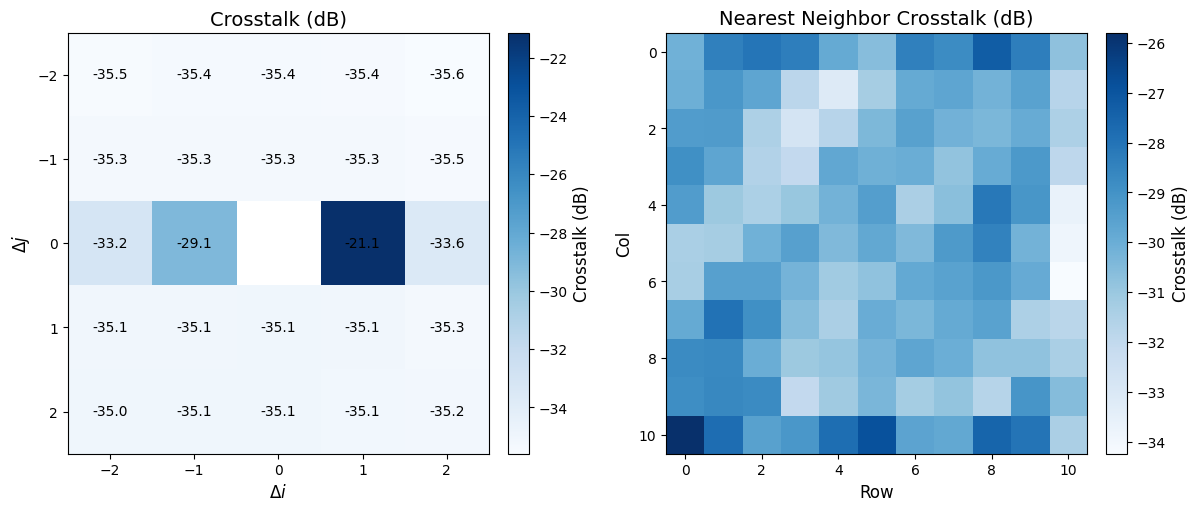

In [31]:
# Improved crosstalk and nearest-neighbor crosstalk plots

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- Crosstalk DB plot ---
ax0 = axes[0]
masked_crosstalk_db = np.ma.array(crosstalk_DB, mask=False)
center_idx = R_max
masked_crosstalk_db[center_idx, center_idx] = np.ma.masked

im0 = ax0.imshow(
    masked_crosstalk_db,
    cmap='Blues',
    extent=[-R_max - 0.5, R_max + 0.5, R_max + 0.5, -R_max - 0.5],
    aspect='equal'
)
ax0.set_xlabel(r'$\Delta i$', fontsize=12)
ax0.set_ylabel(r'$\Delta j$', fontsize=12)
ax0.set_xticks(range(-R_max, R_max + 1))
ax0.set_yticks(range(-R_max, R_max + 1))
ax0.set_title("Crosstalk (dB)", fontsize=14)
for i in range(-R_max, R_max+1):
    for j in range(-R_max, R_max+1):
        if not masked_crosstalk_db.mask[j+R_max, i+R_max]:
            ax0.text(i, j, f'{np.round(crosstalk_DB[j+R_max,i+R_max], 1):.1f}',
                     ha='center', va='center', color='black', fontsize=10)
cb0 = fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
cb0.set_label("Crosstalk (dB)", fontsize=12)

# --- Nearest Neighbor Crosstalk plot ---
ax1 = axes[1]
im1 = ax1.imshow(average_nn_crosstalk, cmap='Blues', aspect='equal')
ax1.set_xlabel("Row", fontsize=12)
ax1.set_ylabel("Col", fontsize=12)
ax1.set_title("Nearest Neighbor Crosstalk (dB)", fontsize=14)
cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cb1.set_label("Crosstalk (dB)", fontsize=12)

plt.show()
